# Customer Churn Clustering

Microsoft has developed "Azure Machine Learning Python client library", which lets you access your Azure ML datasets from your local Python environment. With it, you can:

- Download datasets that are available in your ML workspace;
- Download intermediate datasets that were created within experiments;
- Upload new datasets and update existing datasets;
- Publish your defined functions as web services hosted on Azure;
- Consume published web services on Azure in your Ipython notebook.

Here, we are going to use this customer churn clustering problem as an example to demonstrate how you can utilize this library to integrate your Ipython Notebook with your Azure Machine Learning (Azure ML) workspace.

Note: This is a technology preview. The APIs exposed by the library and the REST endpoints it connects to are subject to change.

For more information, please see a complete documentation <a href="https://github.com/DinoV/Azure-MachineLearning-ClientLibrary-Python/blob/master/README.md">here</a>.

##Initialization
####Import packages and set up plot parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 

from matplotlib import rcParams
dark2_colors = []
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

####Read data from Azure ML workspace

This part of code can be generated from Azure ML studio directly by right/left clicking on the output port of the module.

In [2]:
from azureml import Workspace

ws = Workspace(
    workspace_id='95b0154ab439486da38a3f482c398450',
    authorization_token='104fb4923484478280372f236d15fead',
    endpoint='https://studioapi.azureml.net')
ds = ws.datasets['Customer Churn Data']
churnData = ds.to_dataframe()

#### Data Exploration

First let's see what the data looks like and the size of it.

In [3]:
print('The size of the data: ', churnData.shape)
churnData.head()

('The size of the data: ', (4667, 22))


,X_dataobs_,State,Account_Length,Area_Code,Phone,Int_l_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,...,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn_
0,1,KS,128,415,382-4657,no,yes,25,265.1,110,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,2,OH,107,415,371-7191,no,yes,26,161.6,123,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,3,NJ,137,415,358-1921,no,no,0,243.4,114,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,4,OH,84,408,375-9999,yes,no,0,299.4,71,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,5,OK,75,415,330-6626,yes,no,0,166.7,113,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Then let's see they data type and unique value counts of the columns.

In [4]:
pd.DataFrame({'Data Type': churnData.dtypes, 'Unique Value Counts':churnData.apply(pd.Series.nunique)})

,Data Type,Unique Value Counts
X_dataobs_,int64,4667
State,object,51
Account_Length,int64,217
Area_Code,int64,3
Phone,object,4667
Int_l_Plan,object,2
VMail_Plan,object,2
VMail_Message,int64,48
Day_Mins,float64,1917
Day_Calls,int64,123


##Data Pre-processing

1. Exclude <i>Day_Charge, Eve_Charge, Night_Charge</i> and <i>Intl_Charge</i> columns since these are highly correlated with <i>Day_Mins, Eve_Mins, Night_Mins</i> and <i>Intl_Mins</i>. 
2. Exclude <i>Area_Code, Phone, State, Int_l_Plan</i> and <i>VMail_Plan</i> because they are categorical. K-Means algorithm doesn't deal with categorical variables directly. There are workarounds, but for simplicity, we exclude them here.

In [5]:
churnData = churnData.drop(['Day_Charge', 'Eve_Charge', "Night_Charge", 'Intl_Charge', 'Phone', 'Area_Code', 'State', 'Int_l_Plan', 'VMail_Plan'], axis=1)

####Push the data back to Azure ML workspace.

Note: It would throw an error if you add the data with a name that already exists in the workspace. If you would like to update an existing dataset instead of adding a new dataset, use <i>update_from_dataframe</i>.

In [6]:
from azureml import DataTypeIds

dataset = ws.datasets.add_from_dataframe(
    dataframe=churnData,
    data_type_id=DataTypeIds.GenericCSV,
    name='Customer Churn Clustering Data',
    description='Processed customer churn data for clustering'
)

##K-Means Clustering

####Train the clustering model.

In [19]:
from sklearn.cluster import KMeans

churnKmeans = KMeans(n_clusters=4, n_jobs=4)
churnData['Cluster'] = churnKmeans.fit_predict(churnData[['Account_Length','VMail_Message','Day_Mins','Day_Calls','Eve_Mins',
                        'Eve_Calls','Night_Mins','Night_Calls','Intl_Mins','Intl_Calls','CustServ_Calls']])

Check how many data points there are in each cluster.

In [20]:
unique, counts = np.unique(churnData['Cluster'], return_counts=True)
counts

array([1181, 1131, 1183, 1172])

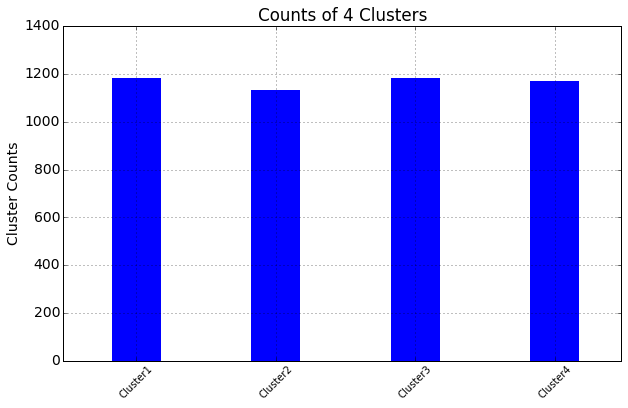

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

ind = np.arange(4)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects = ax.bar(ind, counts, width)

# axes and labels
ax.set_xlim(-width,len(ind)-width)
ax.set_ylim(0,1400)
ax.set_ylabel('Cluster Counts')
ax.set_title('Counts of 4 Clusters')
ax.grid(True)
xTickMarks = ['Cluster'+str(i) for i in range(1,5)]
ax.set_xticks(ind+0.5*width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

plt.show()

Test cluster assignment on a data point.

In [22]:
testData = pd.DataFrame(np.matrix([128,25,265.1,110,197.4,99,244.7,91,10,3,1]), 
                        columns=['Account_Length','VMail_Message','Day_Mins','Day_Calls','Eve_Mins','Eve_Calls','Night_Mins',
                                 'Night_Calls','Intl_Mins','Intl_Calls','CustServ_Calls'])
testData

,Account_Length,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,Night_Calls,Intl_Mins,Intl_Calls,CustServ_Calls
0,128,25,265.1,110,197.4,99,244.7,91,10,3,1


In [23]:
churnKmeans.predict(testData)

array([3], dtype=int32)

## Visualizing Clustering Results

1.	We will create 4 charts which can be used to explore the profiles for each of the clusters. 
2.	The charts will profile Account_Length against each of the following attributes: Day_Mins, Eve_Mins, Intl_Mins, and Night_Mins.

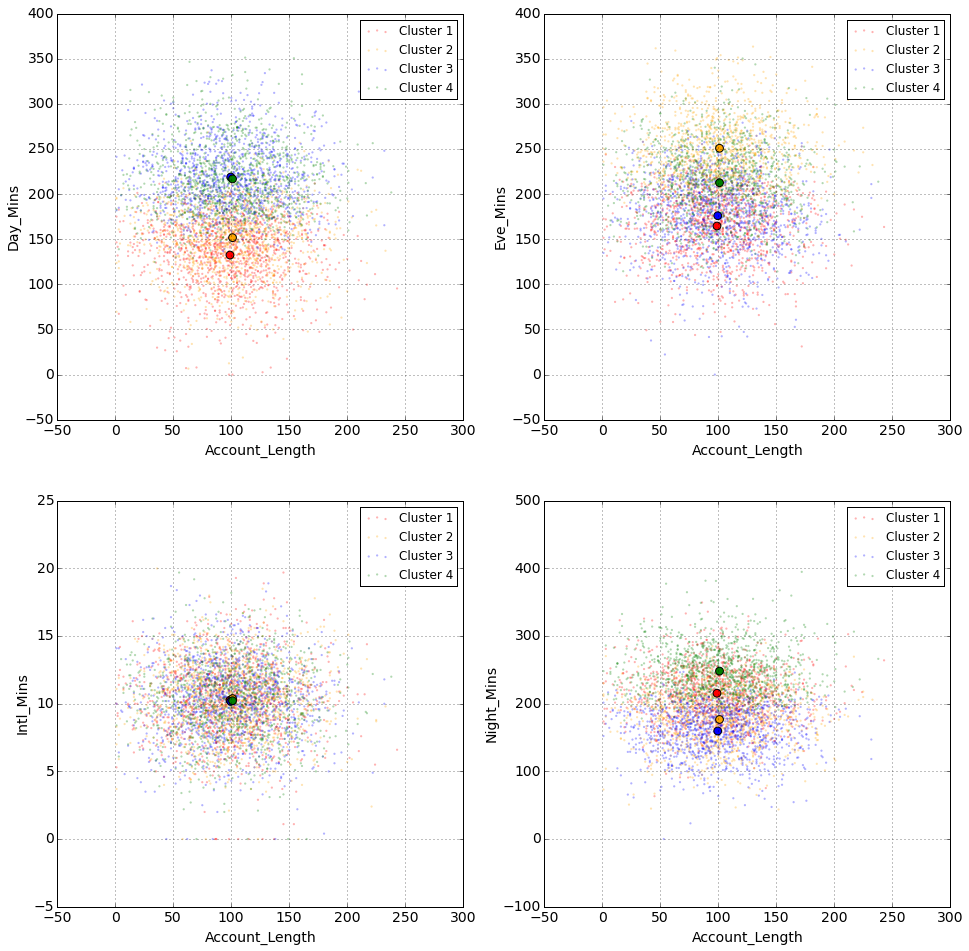

In [24]:
fig = plt.figure(figsize=[16,16])

# Account_Length vs Day_Mins
ax1 = fig.add_subplot(221)
p1 = ax1.scatter(churnData.Account_Length[churnData.Cluster==0], churnData.Day_Mins[churnData.Cluster==0], c='red', s=5, alpha=0.3, edgecolor='none')
p2 = ax1.scatter(churnData.Account_Length[churnData.Cluster==1], churnData.Day_Mins[churnData.Cluster==1], c='orange', s=5, alpha=0.3, edgecolor='none')
p3 = ax1.scatter(churnData.Account_Length[churnData.Cluster==2], churnData.Day_Mins[churnData.Cluster==2], c='blue', s=5, alpha=0.3, edgecolor='none')
p4 = ax1.scatter(churnData.Account_Length[churnData.Cluster==3], churnData.Day_Mins[churnData.Cluster==3], c='green', s=5, alpha=0.3, edgecolor='none')
p5 = ax1.scatter(churnData.groupby('Cluster').Account_Length.mean(), churnData.groupby('Cluster').Day_Mins.mean(), c=['red', 'orange', 'blue', 'green'], s=60, alpha=1, edgecolor='black')

ax1.set_aspect(1./ax1.get_data_ratio()) # make axes square
ax1.set_xlabel('Account_Length')
ax1.set_ylabel('Day_Mins')
ax1.grid(True)
ax1.legend([p1, p2, p3, p4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12)

# Account_Length vs Eve_Mins
ax2 = fig.add_subplot(222)
p1 = ax2.scatter(churnData.Account_Length[churnData.Cluster==0], churnData.Eve_Mins[churnData.Cluster==0], c='red', s=5, alpha=0.3, edgecolor='none')
p2 = ax2.scatter(churnData.Account_Length[churnData.Cluster==1], churnData.Eve_Mins[churnData.Cluster==1], c='orange', s=5, alpha=0.3, edgecolor='none')
p3 = ax2.scatter(churnData.Account_Length[churnData.Cluster==2], churnData.Eve_Mins[churnData.Cluster==2], c='blue', s=5, alpha=0.3, edgecolor='none')
p4 = ax2.scatter(churnData.Account_Length[churnData.Cluster==3], churnData.Eve_Mins[churnData.Cluster==3], c='green', s=5, alpha=0.3, edgecolor='none')
p5 = ax2.scatter(churnData.groupby('Cluster').Account_Length.mean(), churnData.groupby('Cluster').Eve_Mins.mean(), c=['red', 'orange', 'blue', 'green'], s=60, alpha=1, edgecolor='black')

ax2.set_aspect(1./ax2.get_data_ratio()) # make axes square
ax2.set_xlabel('Account_Length')
ax2.set_ylabel('Eve_Mins')
ax2.grid(True)
ax2.legend([p1, p2, p3, p4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12)

# Account_Length vs Intl_Mins
ax3 = fig.add_subplot(223)
p1 = ax3.scatter(churnData.Account_Length[churnData.Cluster==0], churnData.Intl_Mins[churnData.Cluster==0], c='red', s=5, alpha=0.3, edgecolor='none')
p2 = ax3.scatter(churnData.Account_Length[churnData.Cluster==1], churnData.Intl_Mins[churnData.Cluster==1], c='orange', s=5, alpha=0.3, edgecolor='none')
p3 = ax3.scatter(churnData.Account_Length[churnData.Cluster==2], churnData.Intl_Mins[churnData.Cluster==2], c='blue', s=5, alpha=0.3, edgecolor='none')
p4 = ax3.scatter(churnData.Account_Length[churnData.Cluster==3], churnData.Intl_Mins[churnData.Cluster==3], c='green', s=5, alpha=0.3, edgecolor='none')
p5 = ax3.scatter(churnData.groupby('Cluster').Account_Length.mean(), churnData.groupby('Cluster').Intl_Mins.mean(), c=['red', 'orange', 'blue', 'green'], s=60, alpha=1, edgecolor='black')

ax3.set_aspect(1./ax3.get_data_ratio()) # make axes square
ax3.set_xlabel('Account_Length')
ax3.set_ylabel('Intl_Mins')
ax3.grid(True)
ax3.legend([p1, p2, p3, p4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12)

# Account_Length vs Night_Mins
ax4 = fig.add_subplot(224)
p1 = ax4.scatter(churnData.Account_Length[churnData.Cluster==0], churnData.Night_Mins[churnData.Cluster==0], c='red', s=5, alpha=0.3, edgecolor='none')
p2 = ax4.scatter(churnData.Account_Length[churnData.Cluster==1], churnData.Night_Mins[churnData.Cluster==1], c='orange', s=5, alpha=0.3, edgecolor='none')
p3 = ax4.scatter(churnData.Account_Length[churnData.Cluster==2], churnData.Night_Mins[churnData.Cluster==2], c='blue', s=5, alpha=0.3, edgecolor='none')
p4 = ax4.scatter(churnData.Account_Length[churnData.Cluster==3], churnData.Night_Mins[churnData.Cluster==3], c='green', s=5, alpha=0.3, edgecolor='none')
p5 = ax4.scatter(churnData.groupby('Cluster').Account_Length.mean(), churnData.groupby('Cluster').Night_Mins.mean(), c=['red', 'orange', 'blue', 'green'], s=60, alpha=1, edgecolor='black')

ax4.set_aspect(1./ax4.get_data_ratio()) # make axes square
ax4.set_xlabel('Account_Length')
ax4.set_ylabel('Night_Mins')
ax4.grid(True)
ax4.legend([p1, p2, p3, p4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12)

plt.show()

## Publish a Web Service

Now let's publish the clustering model as a web service hosted on Azure, so that you can consume it from anywhere.

In [25]:
from azureml import services 

workspace_id='95b0154ab439486da38a3f482c398450'
authorization_token='104fb4923484478280372f236d15fead'

@services.publish(workspace_id, authorization_token)
@services.types(Account_Length=int, CustServ_Calls=int, Day_Calls=int, Day_Mins=float, Eve_Calls=int, Eve_Mins=float, 
                Intl_Calls=int, Intl_Mins=float, Night_Calls=int, Night_Mins=float, VMail_Message=int)
@services.returns(int)

def CustomerAssignCluster(Account_Length,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,
                          Night_Calls,Intl_Mins,Intl_Calls,CustServ_Calls):
    return churnKmeans.predict([Account_Length,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,
                                Night_Calls,Intl_Mins,Intl_Calls,CustServ_Calls])

You can find out the related information using the following code.
- url: this is the end point for executing the function 
- api_key: this is the API key which is required to invoke the function 
- help_url: this is a human readable page which describes the parameters and results of the function. It also includes sample code for executing it from various languages. 

In [26]:
print('url: ', CustomerAssignCluster.service.url)
print('API Key: ', CustomerAssignCluster.service.api_key)
print('Help: ', CustomerAssignCluster.service.help_url)

('url: ', u'https://ussouthcentral.services.azureml.net/workspaces/95b0154ab439486da38a3f482c398450/services/e7cd246f28dd471d8c5826a4fc9a5cca/execute?api-version=2.0')
('API Key: ', u'TShAsbPaN0K0wx7VIT4S36i8fOFmKNlDh33a78fMZH/0dhSonvksXrPEJeymK7QnX4/B+hm1rrDrIIEJ9vEIWA==')
('Help: ', u'https://studio.azureml.net/apihelp/workspaces/95b0154ab439486da38a3f482c398450/webservices/5a2c41eabc9c4f70874605384bbf9f95/endpoints/e7cd246f28dd471d8c5826a4fc9a5cca/score')


## Consume a Web Service

We can also consume an existing web service from Ipython notebook. With the information of url, api_key, input and output data types, we can create an empty function that calls the web service. Then we can pass input parameters to the function and get the result back.

Let's test this functionality using the web service we just created.

In [60]:
# copy and paste YOUR OWN url and api_key information here
url = 'https://ussouthcentral.services.azureml.net/workspaces/95b0154ab439486da38a3f482c398450/services/e692e380bd13454ea78d859d8ac14e07/execute?api-version=2.0'
api_key = 'pP6PfN06uP7dfIu8xVoNetTz7A3AmJ37imeKADhYC/1lJXXSpHB4rx9aO/RUAVVvXQx5W3hrH5V8RJ2RN3Q68Q=='

@services.service(url, api_key)
@services.types(Account_Length=int, CustServ_Calls=int, Day_Calls=int, Day_Mins=float, Eve_Calls=int, Eve_Mins=float, 
                Intl_Calls=int, Intl_Mins=float, Night_Calls=int, Night_Mins=float, VMail_Message=int)
@services.returns(int)

def CallingWebService(Account_Length,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,
                          Night_Calls,Intl_Mins,Intl_Calls,CustServ_Calls):
    pass

Now that we have created the function <i>CallingWebService</i> that calls the clustering web service, let's test it out.

In [63]:
CallingWebService(128,25,265.1,110,197.4,99,244.7,91,10,3,1)

1